# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=0c028f101780366a9cfed50628a0db35c2891bb93ee5bf89840ec80f58ab354b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

In [ ]:
!pip install kanjize

In [ ]:
!pip install optuna

In [ ]:
!pip install catboost

In [350]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# データ結合(番号を振り直す)
# all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
# max_row = len(all_df)

# データ処理開始

# Ageの処理

In [347]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
train_df["Age"] = train_df["Age"].fillna("-1")

# Ageの処理
for i in range(len(train_df)):
# for i in range(max_row):

  # 末尾文字の取得
  tail = train_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(train_df.loc[i,"Age"][0])!=None):
    tmp = train_df.loc[i,"Age"][:-1]
    train_df.loc[i,"Age"] = kanji2number(tmp)
    train_df.loc[i,"Age"] = int(train_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    train_df.loc[i,"Age"] = train_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    train_df.loc[i,"Age"] = unicodedata.normalize("NFKC", train_df.loc[i,"Age"])
    train_df.loc[i,"Age"] = int(train_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = train_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10代は19歳にする
    if(-1<tmp & tmp<20):
      train_df.loc[i,"Age"] = 19
    elif(tmp>60):
      train_df.loc[i,"Age"] = 61
    else:
      # 10歳で分けて5足す
      tmp = tmp//10 * 10
      train_df.loc[i,"Age"] = tmp + 5

# int型に変換
train_df["Age"] = train_df["Age"].astype(int)

print(train_df.groupby("Age").size())

Age
-1     100
 18      6
 19     12
 20     28
 21     34
 22     43
 23     38
 24     38
 25     99
 26     67
 27     56
 28     74
 29     74
 30     87
 31    109
 32    108
 33    127
 34    112
 35    232
 36    134
 37    118
 38    107
 39    105
 40     95
 41     94
 42     96
 43     91
 44     62
 45    193
 46     75
 47     69
 48     68
 49     68
 50     76
 51     83
 52     83
 53     71
 54     61
 55    128
 56     49
 57     36
 58     33
 59     25
 60     16
 61      5
 65      4
dtype: int64


In [348]:
# カテゴリ列の追加
train_df["Age_cls"] = train_df["Age"].copy()

train_df.loc[train_df["Age"]<0,"Age_cls"] = "不明"
train_df.loc[(train_df["Age"]>=10) & (train_df["Age"]<=20),"Age_cls"] = "20歳以下"
train_df.loc[(train_df["Age"]>=21) & (train_df["Age"]<=25),"Age_cls"] = "21〜25歳"
train_df.loc[(train_df["Age"]>=26) & (train_df["Age"]<=30),"Age_cls"] = "26〜30歳"
train_df.loc[(train_df["Age"]>=31) & (train_df["Age"]<=35),"Age_cls"] = "31〜35歳"
train_df.loc[(train_df["Age"]>=36) & (train_df["Age"]<=40),"Age_cls"] = "36〜40歳"
train_df.loc[(train_df["Age"]>=41) & (train_df["Age"]<=45),"Age_cls"] = "41〜45歳"
train_df.loc[(train_df["Age"]>=46) & (train_df["Age"]<=50),"Age_cls"] = "46〜50歳"
train_df.loc[(train_df["Age"]>=51) & (train_df["Age"]<=55),"Age_cls"] = "51〜55歳"
train_df.loc[train_df["Age"]>=56,"Age_cls"] = "56歳以上"

# 元のカラムを削除する
# train_df = train_df.drop("Age",axis=1)

train_df['Age_cls'] = train_df['Age_cls'].astype('object')
print(train_df.groupby(["Age_cls"]).size())

Age_cls
20歳以下      46
21〜25歳    252
26〜30歳    358
31〜35歳    688
36〜40歳    559
41〜45歳    536
46〜50歳    356
51〜55歳    426
56歳以上     168
不明        100
dtype: int64


<ipython-input-348-2c3117900dbf>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df["Age"]<0,"Age_cls"] = "不明"


In [351]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
test_df["Age"] = test_df["Age"].fillna("-1")

# Ageの処理
for i in range(len(test_df)):
# for i in range(max_row):

  # 末尾文字の取得
  tail = test_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(test_df.loc[i,"Age"][0])!=None):
    tmp = test_df.loc[i,"Age"][:-1]
    test_df.loc[i,"Age"] = kanji2number(tmp)
    test_df.loc[i,"Age"] = int(test_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    test_df.loc[i,"Age"] = test_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    test_df.loc[i,"Age"] = unicodedata.normalize("NFKC", test_df.loc[i,"Age"])
    test_df.loc[i,"Age"] = int(test_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = test_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10代は19歳にする
    if(-1<tmp & tmp<20):
      test_df.loc[i,"Age"] = 19
    elif(tmp>60):
      test_df.loc[i,"Age"] = 61
    else:
      # 10歳で分けて5足す
      tmp = tmp//10 * 10
      test_df.loc[i,"Age"] = tmp + 5

# int型に変換
test_df["Age"] = test_df["Age"].astype(int)

print(test_df.groupby("Age").size())

Age
-1      93
 18     11
 19     16
 20     19
 21     24
 22     38
 23     36
 24     58
 25     94
 26     56
 27     66
 28     86
 29     84
 30    107
 31    108
 32    126
 33    136
 34    122
 35    237
 36    123
 37    120
 38     99
 39     99
 40     93
 41     92
 42    102
 43     79
 44     67
 45    161
 46     71
 47     75
 48     57
 49     68
 50     89
 51     73
 52     71
 53     60
 54     70
 55    124
 56     48
 57     50
 58     30
 59     28
 60     14
 61      9
dtype: int64


In [352]:
# カテゴリ列の追加
test_df["Age_cls"] = test_df["Age"].copy()

test_df.loc[test_df["Age"]<0,"Age_cls"] = "不明"
test_df.loc[(test_df["Age"]>=10) & (test_df["Age"]<=20),"Age_cls"] = "20歳以下"
test_df.loc[(test_df["Age"]>=21) & (test_df["Age"]<=25),"Age_cls"] = "21〜25歳"
test_df.loc[(test_df["Age"]>=26) & (test_df["Age"]<=30),"Age_cls"] = "26〜30歳"
test_df.loc[(test_df["Age"]>=31) & (test_df["Age"]<=35),"Age_cls"] = "31〜35歳"
test_df.loc[(test_df["Age"]>=36) & (test_df["Age"]<=40),"Age_cls"] = "36〜40歳"
test_df.loc[(test_df["Age"]>=41) & (test_df["Age"]<=45),"Age_cls"] = "41〜45歳"
test_df.loc[(test_df["Age"]>=46) & (test_df["Age"]<=50),"Age_cls"] = "46〜50歳"
test_df.loc[(test_df["Age"]>=51) & (test_df["Age"]<=55),"Age_cls"] = "51〜55歳"
test_df.loc[test_df["Age"]>=56,"Age_cls"] = "56歳以上"

# 元のカラムを削除する
# test_df = test_df.drop("Age",axis=1)

test_df['Age_cls'] = test_df['Age_cls'].astype('object')
print(test_df.groupby(["Age_cls"]).size())

Age_cls
20歳以下      46
21〜25歳    250
26〜30歳    399
31〜35歳    729
36〜40歳    534
41〜45歳    501
46〜50歳    360
51〜55歳    398
56歳以上     179
不明         93
dtype: int64


<ipython-input-352-9e98d409d643>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.loc[test_df["Age"]<0,"Age_cls"] = "不明"


In [314]:
#########################
# "TypeofContact"の処理 #
#########################
print(all_df.groupby("TypeofContact").size())

TypeofContact
Company Invited    2516
Self Enquiry       4444
dtype: int64


In [315]:
# 欠損は最頻値で補完する
# all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")
print(all_df.groupby("TypeofContact").size())

TypeofContact
Company Invited    2516
Self Enquiry       4444
dtype: int64


In [316]:
#########################
# "CityTier"の処理 #
#########################
print(all_df.groupby("CityTier").size())

CityTier
1    2991
2    3160
3     827
dtype: int64


In [317]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(len(all_df)):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

# int型に変換
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("int")

# 秒に換算
all_df["DurationOfPitch"] = all_df["DurationOfPitch"] * 60
print(all_df.groupby("DurationOfPitch").size())

DurationOfPitch
-60      252
 240       3
 300      43
 360     167
 420     446
 480     671
 540     654
 600     467
 660     306
 720     293
 780     397
 840     518
 900     569
 960     527
 1020    312
 1080    133
 1140     50
 1200     66
 1260     65
 1320     84
 1380    104
 1440     86
 1500     79
 1560     64
 1620     57
 1680     56
 1740     48
 1800     65
 1860     86
 1920     93
 1980     69
 2040     75
 2100     58
 2160     15
dtype: int64


In [318]:
# カテゴリ列の追加
all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch"].copy()

all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"
all_df.loc[(all_df["DurationOfPitch"]>0) & (all_df["DurationOfPitch"]<=400),"DurationOfPitch_cls"] = "400s以下"
all_df.loc[(all_df["DurationOfPitch"]>400) & (all_df["DurationOfPitch"]<=500),"DurationOfPitch_cls"] = "401〜500s"
all_df.loc[(all_df["DurationOfPitch"]>500) & (all_df["DurationOfPitch"]<=600),"DurationOfPitch_cls"] = "501〜600s"
all_df.loc[(all_df["DurationOfPitch"]>600) & (all_df["DurationOfPitch"]<=700),"DurationOfPitch_cls"] = "601〜700s"
all_df.loc[(all_df["DurationOfPitch"]>700) & (all_df["DurationOfPitch"]<=800),"DurationOfPitch_cls"] = "701〜800s"
all_df.loc[(all_df["DurationOfPitch"]>800) & (all_df["DurationOfPitch"]<=900),"DurationOfPitch_cls"] = "801〜900s"
all_df.loc[(all_df["DurationOfPitch"]>900) & (all_df["DurationOfPitch"]<=1000),"DurationOfPitch_cls"] = "901〜1000s"
all_df.loc[(all_df["DurationOfPitch"]>1000) & (all_df["DurationOfPitch"]<=1100),"DurationOfPitch_cls"] = "1001〜1100s"
all_df.loc[(all_df["DurationOfPitch"]>1100) & (all_df["DurationOfPitch"]<=1200),"DurationOfPitch_cls"] = "1101〜1200s"
all_df.loc[(all_df["DurationOfPitch"]>1200) & (all_df["DurationOfPitch"]<=1300),"DurationOfPitch_cls"] = "1201〜1300s"
all_df.loc[(all_df["DurationOfPitch"]>1300) & (all_df["DurationOfPitch"]<=1400),"DurationOfPitch_cls"] = "1301〜1400s"
all_df.loc[(all_df["DurationOfPitch"]>1400) & (all_df["DurationOfPitch"]<=1500),"DurationOfPitch_cls"] = "1401〜1500s"
all_df.loc[all_df["DurationOfPitch"]>1500,"DurationOfPitch_cls"] = "1501s以上"

# 元のカラムを削除
# all_df = all_df.drop("DurationOfPitch", axis=1)

all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch_cls"].astype("object")
print(all_df.groupby(["DurationOfPitch_cls"]).size())

DurationOfPitch_cls
1001〜1100s     445
1101〜1200s     116
1201〜1300s      65
1301〜1400s     188
1401〜1500s     165
1501s以上        686
400s以下         213
401〜500s      1117
501〜600s      1121
601〜700s       306
701〜800s       690
801〜900s      1087
901〜1000s      527
不明             252
dtype: int64


<ipython-input-318-57a532ae39e6>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"


In [319]:
####################
# "Occupation"の処理 #
####################
print(all_df.groupby(["Occupation"]).size())

Occupation
Large Business     721
Salaried          2801
Small Business    3456
dtype: int64


In [320]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1]).lower()
  if(head == "f"):
    all_df.loc[i,"Gender"] = "Female"
  else:
    all_df.loc[i,"Gender"] = "Male"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("object")
print(all_df.groupby(["Gender"]).size())

Gender
Female    2760
Male      4218
dtype: int64


In [321]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df.groupby(["NumberOfPersonVisiting"]).size())

NumberOfPersonVisiting
1.0     686
2.0    3163
3.0    2773
4.0     356
dtype: int64


In [322]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# 欠損を-1で埋める
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df.groupby(["NumberOfFollowups"]).size())

NumberOfFollowups
-1.0      57
 1.0     178
 2.0     213
 3.0    2561
 4.0    2777
 5.0    1122
 6.0      70
dtype: int64


In [323]:
# カテゴリ列の追加
all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups"].copy()

all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"
all_df.loc[all_df["NumberOfFollowups"]==1,"NumberOfFollowups_cls"] = "1回"
all_df.loc[all_df["NumberOfFollowups"]==2,"NumberOfFollowups_cls"] = "2回"
all_df.loc[all_df["NumberOfFollowups"]==3,"NumberOfFollowups_cls"] = "3回"
all_df.loc[all_df["NumberOfFollowups"]==4,"NumberOfFollowups_cls"] = "4回"
all_df.loc[all_df["NumberOfFollowups"]==5,"NumberOfFollowups_cls"] = "5回"
all_df.loc[all_df["NumberOfFollowups"]==6,"NumberOfFollowups_cls"] = "6回"

# 元のカラムを削除する
# all_df = all_df.drop("NumberOfFollowups", axis=1)

all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups_cls"].astype("object")
print(all_df.groupby(["NumberOfFollowups_cls"]).size())

NumberOfFollowups_cls
1回     178
2回     213
3回    2561
4回    2777
5回    1122
6回      70
不明      57
dtype: int64


<ipython-input-323-90adc46ed6cf>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"


In [324]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("object")

# 分布の確認
print(all_df.groupby(["ProductPitched"]).size())

ProductPitched
Basic          2347
Deluxe         2091
King            286
Standard       1614
SuperDeluxe     640
dtype: int64


In [325]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
print(all_df.groupby(["PreferredPropertyStar"]).size())

PreferredPropertyStar
3.0    4328
4.0    2254
5.0     396
dtype: int64


In [326]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips_num"] = [0]*len(all_df)
all_df["NumberOfTrips_num"] = -1

all_df["NumberOfTrips_num"] = all_df["NumberOfTrips_num"].astype(int)

all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][2:3])

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][3:4])*2

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][4:5])*4

  elif(head == "-1"):
    all_df.loc[i,"NumberOfTrips_num"] = -1

  else:
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"])

print(all_df.groupby(["NumberOfTrips_num"]).size())

NumberOfTrips_num
-1      64
 1     801
 2    2277
 3    1706
 4     333
 5     977
 6     281
 7     513
 8      26
dtype: int64


In [327]:
# 欠損は最頻値で補完
# all_df.loc[all_df["NumberOfTrips_num"]<0,"NumberOfTrips_num"] = (all_df.loc[all_df["NumberOfTrips_num"]>0,["NumberOfTrips_num"]]).mode().values

all_df["NumberOfTrips"] = all_df["NumberOfTrips_num"].copy()
# all_df = all_df.drop("NumberOfTrips_num", axis=1)
print(all_df.groupby(["NumberOfTrips"]).size())

NumberOfTrips
-1      64
 1     801
 2    2277
 3    1706
 4     333
 5     977
 6     281
 7     513
 8      26
dtype: int64


In [328]:
#########################
# "Passport"の処理 #
#########################
print(all_df.groupby(["Passport"]).size())

Passport
0    6288
1     690
dtype: int64


In [329]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df.groupby(["PitchSatisfactionScore"]).size())

PitchSatisfactionScore
1    1439
2    2500
3    1344
4    1452
5     243
dtype: int64


In [330]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("object")

# 分布の確認
print(all_df.groupby(["Designation"]).size())

Designation
AVP                635
Executive         2330
Manager           2117
Senior Manager    1632
VP                 264
dtype: int64


In [331]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

print(all_df.groupby(["MonthlyIncome"]).size())

MonthlyIncome
-1.0         105
 200000.0      5
 238890.0      1
 239340.0      1
 240000.0      2
            ... 
 578460.0      1
 578490.0      1
 578670.0      1
 579015.0      1
 600000.0     10
Length: 4586, dtype: int64


In [332]:
all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"
all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<=250000),"MonthlyIncome_cls"] = "25万円以下"
all_df.loc[(all_df["MonthlyIncome"]>250000) & (all_df["MonthlyIncome"]<=300000),"MonthlyIncome_cls"] = "25〜30万円"
all_df.loc[(all_df["MonthlyIncome"]>300000) & (all_df["MonthlyIncome"]<=350000),"MonthlyIncome_cls"] = "30〜35万円"
all_df.loc[(all_df["MonthlyIncome"]>350000) & (all_df["MonthlyIncome"]<=400000),"MonthlyIncome_cls"] = "35〜40万円"
all_df.loc[(all_df["MonthlyIncome"]>400000), "MonthlyIncome_cls"] = "40万円以上"

# all_df = all_df.drop("MonthlyIncome", axis=1)

print(all_df.groupby(["MonthlyIncome_cls"]).size())

MonthlyIncome_cls
25〜30万円    1679
25万円以下       71
30〜35万円    2035
35〜40万円    1554
40万円以上     1534
不明          105
dtype: int64


<ipython-input-332-149bd5a7df1c>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"


In [333]:
# ProdTaken
print(all_df.groupby(["ProdTaken"]).size())

ProdTaken
0.0    2992
1.0     497
dtype: int64


In [334]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」、「わからない」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭") or (cont[i][-1:] == "い")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」
  else:
    c_other.append(cont[i])

In [335]:
# 新たなカラムを追加
all_df["CarHolder"] = "自動車未所有" # 車所有
all_df["NumofChild"] = "不明" # 子供の数
all_df["Married"] = "独身" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有",
              "車未所持","自動車未所有","車保有なし","乗用車なし","自家用車なし","車なし"]

# 子供
c_child_x = ['子育て状況不明', '子の数不詳', '子供の数不明','わからない',"子供有り"]
c_child_0 = ['子供なし', '子供無し', '無子', '子供ゼロ', '非育児家庭']
c_child_1 = ["こども1人","1児","子供1人","子供有り(1人)"]
c_child_2 = ["こども2人","2児","子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児","子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        if(tmp[j] in ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有"]):
          all_df.loc[i, "CarHolder"] = "自動車所有"
      # 子供の情報
      if(tmp[j] in c_child_x):
        all_df.loc[i, "NumofChild"] = "不明"
      if(tmp[j] in c_child_0):
        all_df.loc[i, "NumofChild"] = "子供なし"
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = "子供1人"
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = "子供2人"
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = "子供3人"
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "結婚済み"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "離婚済み"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [336]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("object")
print(all_df.groupby(["CarHolder"]).size())

CarHolder
自動車所有     3359
自動車未所有    3619
dtype: int64


In [337]:
# 子供の数
all_df["NumofChild"] = all_df["NumofChild"].astype("object")
print(all_df.groupby(["NumofChild"]).size())

NumofChild
不明       395
子供1人    2945
子供2人    1600
子供3人     129
子供なし    1909
dtype: int64


In [338]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("object")
print(all_df.groupby(["Married"]).size())

Married
独身      2444
結婚済み    2846
離婚済み    1688
dtype: int64


In [339]:
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'NumberOfTrips_num', 'MonthlyIncome_cls', 'CarHolder', 'NumofChild',
       'Married'],
      dtype='object')

In [343]:
print(all_df.dtypes)

id                          int64
Age                         int64
TypeofContact              object
CityTier                    int64
DurationOfPitch             int64
Occupation                 object
Gender                     object
NumberOfPersonVisiting    float64
NumberOfFollowups         float64
ProductPitched             object
PreferredPropertyStar     float64
NumberOfTrips               int64
Passport                    int64
PitchSatisfactionScore      int64
Designation                object
MonthlyIncome             float64
ProdTaken                 float64
Age_cls                    object
DurationOfPitch_cls        object
NumberOfFollowups_cls      object
NumberOfTrips_num           int64
MonthlyIncome_cls          object
CarHolder                  object
NumofChild                 object
Married                    object
dtype: object


In [344]:
# カテゴリ化した数値カラム削除
all_df = all_df.drop(["Age", "DurationOfPitch", "NumberOfTrips_num", "NumberOfFollowups", "MonthlyIncome"],axis=1)

In [345]:
# 欠損値補完
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6978 entries, 0 to 6977
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6978 non-null   int64  
 1   TypeofContact           6960 non-null   object 
 2   CityTier                6978 non-null   int64  
 3   Occupation              6978 non-null   object 
 4   Gender                  6978 non-null   object 
 5   NumberOfPersonVisiting  6978 non-null   float64
 6   ProductPitched          6978 non-null   object 
 7   PreferredPropertyStar   6978 non-null   float64
 8   NumberOfTrips           6978 non-null   int64  
 9   Passport                6978 non-null   int64  
 10  PitchSatisfactionScore  6978 non-null   int64  
 11  Designation             6978 non-null   object 
 12  ProdTaken               3489 non-null   float64
 13  Age_cls                 6978 non-null   object 
 14  DurationOfPitch_cls     6978 non-null   

In [ ]:
all_df.fillna(train_df.mode().iloc[0], inplace=True)

In [340]:
# 順番を整列させる
# col = ['id', 'TypeofContact', 'CityTier', 'Occupation', 'Gender',
#        'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
#        'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
#        'ProdTaken', 'Married', 'CarHolder', 'NumofChild', 'Age_cls',
#        'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'MonthlyIncome_cls'
#        ]

# all_df = all_df.reindex(columns=col)

In [275]:
len(col)

20

In [274]:
CATS = []
for c in col:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'Designation', 'Married', 'CarHolder', 'NumofChild', 'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'MonthlyIncome_cls']


In [196]:
all_df_forcorr = all_df.drop(CATS, axis=1)

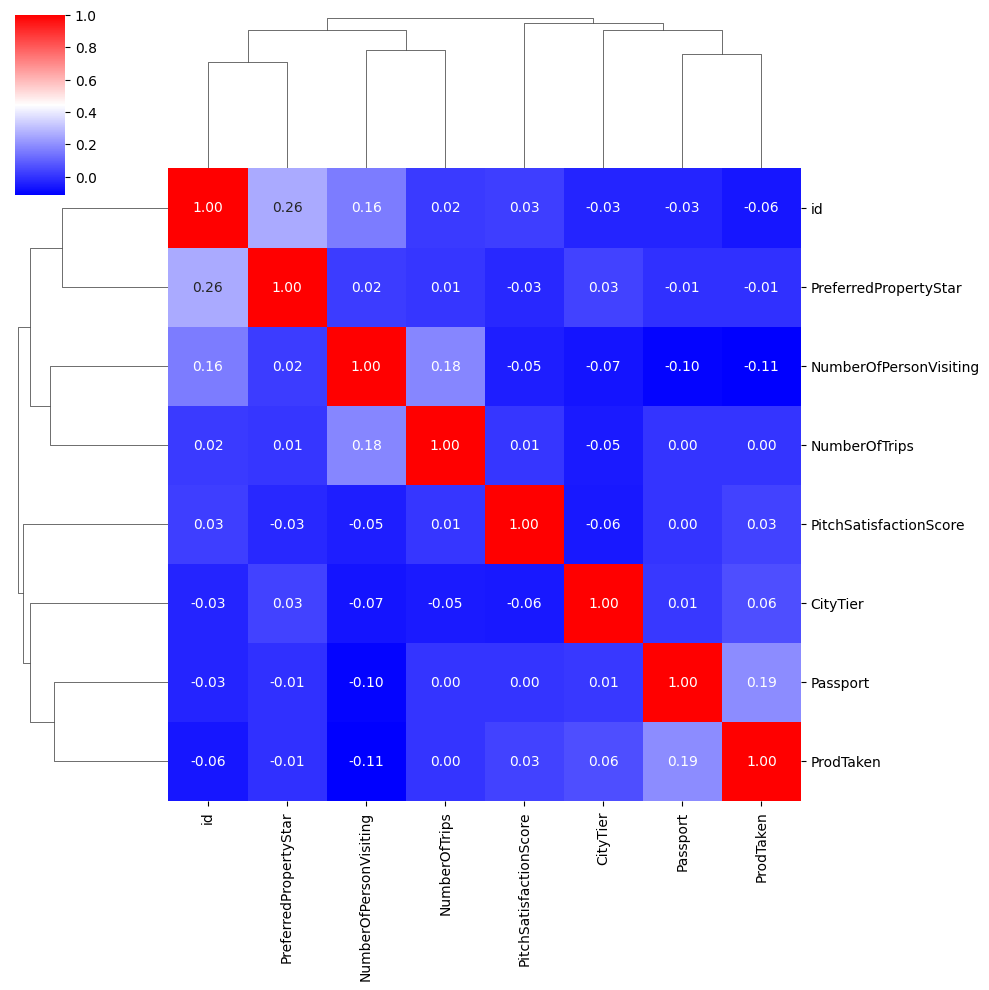

In [197]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df_forcorr.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

# 学習準備

# ここから学習作業

In [276]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [277]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 学習データ
train_x = train.drop(TARGET,axis=1)
train_y = train[TARGET]
test = test.drop(TARGET,axis=1)

# 対象の列のみ取り込み
FEATURES = test.columns

In [278]:
# オブジェクト型を抽出する
categorical_features = train_x.select_dtypes(include=['object']).columns.tolist()

In [279]:
for feature in train_x.columns:
    print(train_x.groupby(feature).size())
    print("")

Age
-1     100
 18      6
 19     12
 20     28
 21     34
 22     43
 23     38
 24     38
 25     99
 26     67
 27     56
 28     74
 29     74
 30     87
 31    109
 32    108
 33    127
 34    112
 35    232
 36    134
 37    118
 38    107
 39    105
 40     95
 41     94
 42     96
 43     91
 44     62
 45    193
 46     75
 47     69
 48     68
 49     68
 50     76
 51     83
 52     83
 53     71
 54     61
 55    128
 56     49
 57     36
 58     33
 59     25
 60     16
 61      5
 65      4
dtype: int64

TypeofContact
Company Invited    1289
Self Enquiry       2194
dtype: int64

CityTier
1    1475
2    1596
3     418
dtype: int64

DurationOfPitch
-60      121
 240       2
 300      18
 360      80
 420     239
 480     338
 540     327
 600     231
 660     160
 720     158
 780     203
 840     266
 900     284
 960     259
 1020    136
 1080     74
 1140     19
 1200     36
 1260     31
 1320     45
 1380     51
 1440     40
 1500     38
 1560     27
 1620     35
 1680 

In [217]:
import pandas as pd
import numpy as np
import optuna
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.model_selection import train_test_split, StratifiedKFold
import sklearn.metrics

In [218]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 4, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50),
        'eval_metric' :'AUC',
    }

  # KFold
  skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=32)
  auc_score = []
  pred_score = []
  pred_test_df = test_df.drop(["id"], axis=1)

  for fold, (train_idx, val_idx) in enumerate(skf.split(train_x, train_y), start=0):
      X_train = train_x.iloc[train_idx, :]
      y_train = train_y[train_idx]
      X_val = train_x.iloc[val_idx, :]
      y_val = train_y[val_idx]

      # cb_model = CatBoostClassifier(**params, task_type="GPU")
      cb_model = CatBoostClassifier(**params)

      cb_model.fit(
            X_train, y_train,
            cat_features=categorical_features,
            eval_set=(X_val, y_val),
            use_best_model=True,
            verbose=False,
          )

      # AUC算出
      auc_score.append(cb_model.get_best_score()["validation"]["AUC"])
      # # testデータのスコア算出
      # pred_score.append(cb_model.predict_proba(pred_test_df)[:,1])

  return sum(auc_score)/len(auc_score)

In [219]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-05-31 12:15:55,061] A new study created in memory with name: no-name-4a49183c-cb64-4097-ab6f-6724cc151388
<ipython-input-218-bc4e861db822>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-218-bc4e861db822>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
[I 2025-05-31 12:15:56,281] Trial 0 finished with value: 0.8365866696601064 and parameters: {'iterations': 112, 'depth': 10, 'learning_rate': 0.28758782805158634, 'random_strength': 12, 'bagging_temperature': 4.604299293749796, 'od_type': '

In [220]:
print(study.best_trial)
print(study.best_params)

FrozenTrial(number=51, state=1, values=[0.8428251335146513], datetime_start=datetime.datetime(2025, 5, 31, 12, 19, 14, 484619), datetime_complete=datetime.datetime(2025, 5, 31, 12, 19, 17, 446972), params={'iterations': 192, 'depth': 6, 'learning_rate': 0.24878147581481436, 'random_strength': 98, 'bagging_temperature': 60.185843586749414, 'od_type': 'IncToDec', 'od_wait': 13}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=300, log=False, low=50, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'random_strength': IntDistribution(high=100, log=False, low=0, step=1), 'bagging_temperature': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'od_type': CategoricalDistribution(choices=('IncToDec', 'Iter')), 'od_wait': IntDistribution(high=50, log=False, low=10, step=1)}, trial_id=51, value=None)
{'iterations': 192, 'depth': 6

In [221]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'iterations': 192, 'depth': 6, 'learning_rate': 0.24878147581481436, 'random_strength': 98, 'bagging_temperature': 60.185843586749414, 'od_type': 'IncToDec', 'od_wait': 13}
[0.8428251335146513]


In [222]:
best_params = study.best_params

In [223]:
best_params['eval_metric'] = 'AUC'

In [224]:
best_params

{'iterations': 192,
 'depth': 6,
 'learning_rate': 0.24878147581481436,
 'random_strength': 98,
 'bagging_temperature': 60.185843586749414,
 'od_type': 'IncToDec',
 'od_wait': 13,
 'eval_metric': 'AUC'}

In [235]:
best_params = {'iterations': 171,
 'depth': 6,
 'learning_rate': 0.29397858515878483,
 'random_strength': 68,
 'bagging_temperature': 1.809748091233205,
 'od_type': 'IncToDec',
 'od_wait': 30,
 'eval_metric': 'AUC'}

In [236]:
train_pred_df = pd.DataFrame()
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=32)
auc_score = []
pred_score = []
pred_test_df = test
models = []

for fold, (train_idx, val_idx) in enumerate(cv.split(train_x, train_y), start=0):
    X_train = train_x.iloc[train_idx, :]
    y_train = train_y[train_idx]
    X_val = train_x.iloc[val_idx, :]
    y_val = train_y[val_idx]

    cb_model = CatBoostClassifier(**best_params)

    cb_model.fit(
         X_train, y_train,
         cat_features=categorical_features,
         eval_set=(X_val, y_val),
         use_best_model=True,
         verbose=True,
        )

    # モデル記録
    models.append(cb_model)

    # AUC算出
    auc_score.append(cb_model.get_best_score()["validation"]["AUC"])
    # testデータのスコア算出
    pred_score.append(cb_model.predict_proba(pred_test_df)[:,1])
    # trainデータのスコア算出
    pred_valid = cb_model.predict_proba(X_val)[:,1]
    tmp_df = pd.DataFrame(
        {
            "catboost_Score": pred_valid,
            "true": y_val,
        },
        index=X_val.index,
    )
    train_pred_df = pd.concat([train_pred_df, tmp_df], axis=0)
train_pred_df = train_pred_df.sort_index()

0:	test: 0.5058740	best: 0.5058740 (0)	total: 1.33ms	remaining: 226ms
1:	test: 0.5245327	best: 0.5245327 (1)	total: 2.56ms	remaining: 217ms
2:	test: 0.7348789	best: 0.7348789 (2)	total: 3.89ms	remaining: 218ms
3:	test: 0.7379393	best: 0.7379393 (3)	total: 5.09ms	remaining: 213ms
4:	test: 0.7379393	best: 0.7379393 (3)	total: 6.3ms	remaining: 209ms
5:	test: 0.7572562	best: 0.7572562 (5)	total: 8.13ms	remaining: 223ms
6:	test: 0.7572562	best: 0.7572562 (5)	total: 8.94ms	remaining: 209ms
7:	test: 0.7639529	best: 0.7639529 (7)	total: 10.6ms	remaining: 216ms
8:	test: 0.7639529	best: 0.7639529 (7)	total: 11.5ms	remaining: 207ms
9:	test: 0.7620113	best: 0.7639529 (7)	total: 13.3ms	remaining: 214ms
10:	test: 0.7503784	best: 0.7639529 (7)	total: 15.2ms	remaining: 220ms
11:	test: 0.7503784	best: 0.7639529 (7)	total: 15.8ms	remaining: 210ms
12:	test: 0.7503784	best: 0.7639529 (7)	total: 16.5ms	remaining: 200ms
13:	test: 0.7503784	best: 0.7639529 (7)	total: 17.2ms	remaining: 193ms
14:	test: 0.75297

In [237]:
auc_score

[0.8410885876003685,
 0.848229564301698,
 0.8307884691325523,
 0.8314147178150872,
 0.8505458983408649,
 0.8403206121977769,
 0.8278193752680014]

In [239]:
sum(auc_score)/len(auc_score)

0.8386010320937644

In [240]:
average_pred = np.mean(pred_score, axis=0)

In [241]:
print(pred_score)
print(average_pred)

[array([0.10618387, 0.25994995, 0.33145697, ..., 0.75729794, 0.3389481 ,
       0.0113539 ]), array([0.0689022 , 0.17391266, 0.41078521, ..., 0.75846559, 0.22540911,
       0.00783531]), array([0.13001582, 0.15886912, 0.28969492, ..., 0.74844269, 0.30349036,
       0.00330859]), array([0.07735266, 0.41796522, 0.26640222, ..., 0.71744022, 0.32282855,
       0.01532488]), array([0.07034423, 0.21385756, 0.20188747, ..., 0.67905978, 0.24323505,
       0.01465223]), array([0.07803157, 0.28518376, 0.26406005, ..., 0.6808026 , 0.31511255,
       0.02474424]), array([0.12958292, 0.32752835, 0.19164964, ..., 0.74430786, 0.35974989,
       0.01818871])]
[0.09434475 0.26246666 0.2794195  ... 0.72654524 0.30125337 0.01362969]


In [242]:
submit_df = pd.read_csv("/content/sample_submit.csv", header=None)
submit_df.head()
submit_df[1] = average_pred
submit_df.to_csv("submit.csv", index=False, header=None)

# 重要度を比較する

In [231]:
# 重要度の算出
feature_importances = 0
for i in range(5):
  feature_importances += pd.DataFrame(models[i].get_feature_importance(),columns=['importance'])

feature=pd.DataFrame(test.columns,columns=['feature'])
o=pd.concat([feature,feature_importances],axis=1)
o = o.sort_values("importance", ascending=False)
print(o)

                   feature  importance
5           ProductPitched   84.094312
17       MonthlyIncome_cls   51.384231
10             Designation   49.537679
8                 Passport   48.697108
11                 Married   36.213440
1                 CityTier   30.983876
14                 Age_cls   30.646054
3                   Gender   25.640344
9   PitchSatisfactionScore   21.571876
7            NumberOfTrips   19.760686
13              NumofChild   17.558889
2               Occupation   16.946187
0            TypeofContact   14.056446
16   NumberOfFollowups_cls   13.519468
15     DurationOfPitch_cls   13.305707
4   NumberOfPersonVisiting   13.157142
6    PreferredPropertyStar    6.655367
12               CarHolder    6.271188


In [232]:
o

,feature,importance
5,ProductPitched,84.094312
17,MonthlyIncome_cls,51.384231
10,Designation,49.537679
8,Passport,48.697108
11,Married,36.213440
1,CityTier,30.983876
14,Age_cls,30.646054
3,Gender,25.640344
9,PitchSatisfactionScore,21.571876
7,NumberOfTrips,19.760686


Text(0.5, 1.0, 'Feature Importances ')

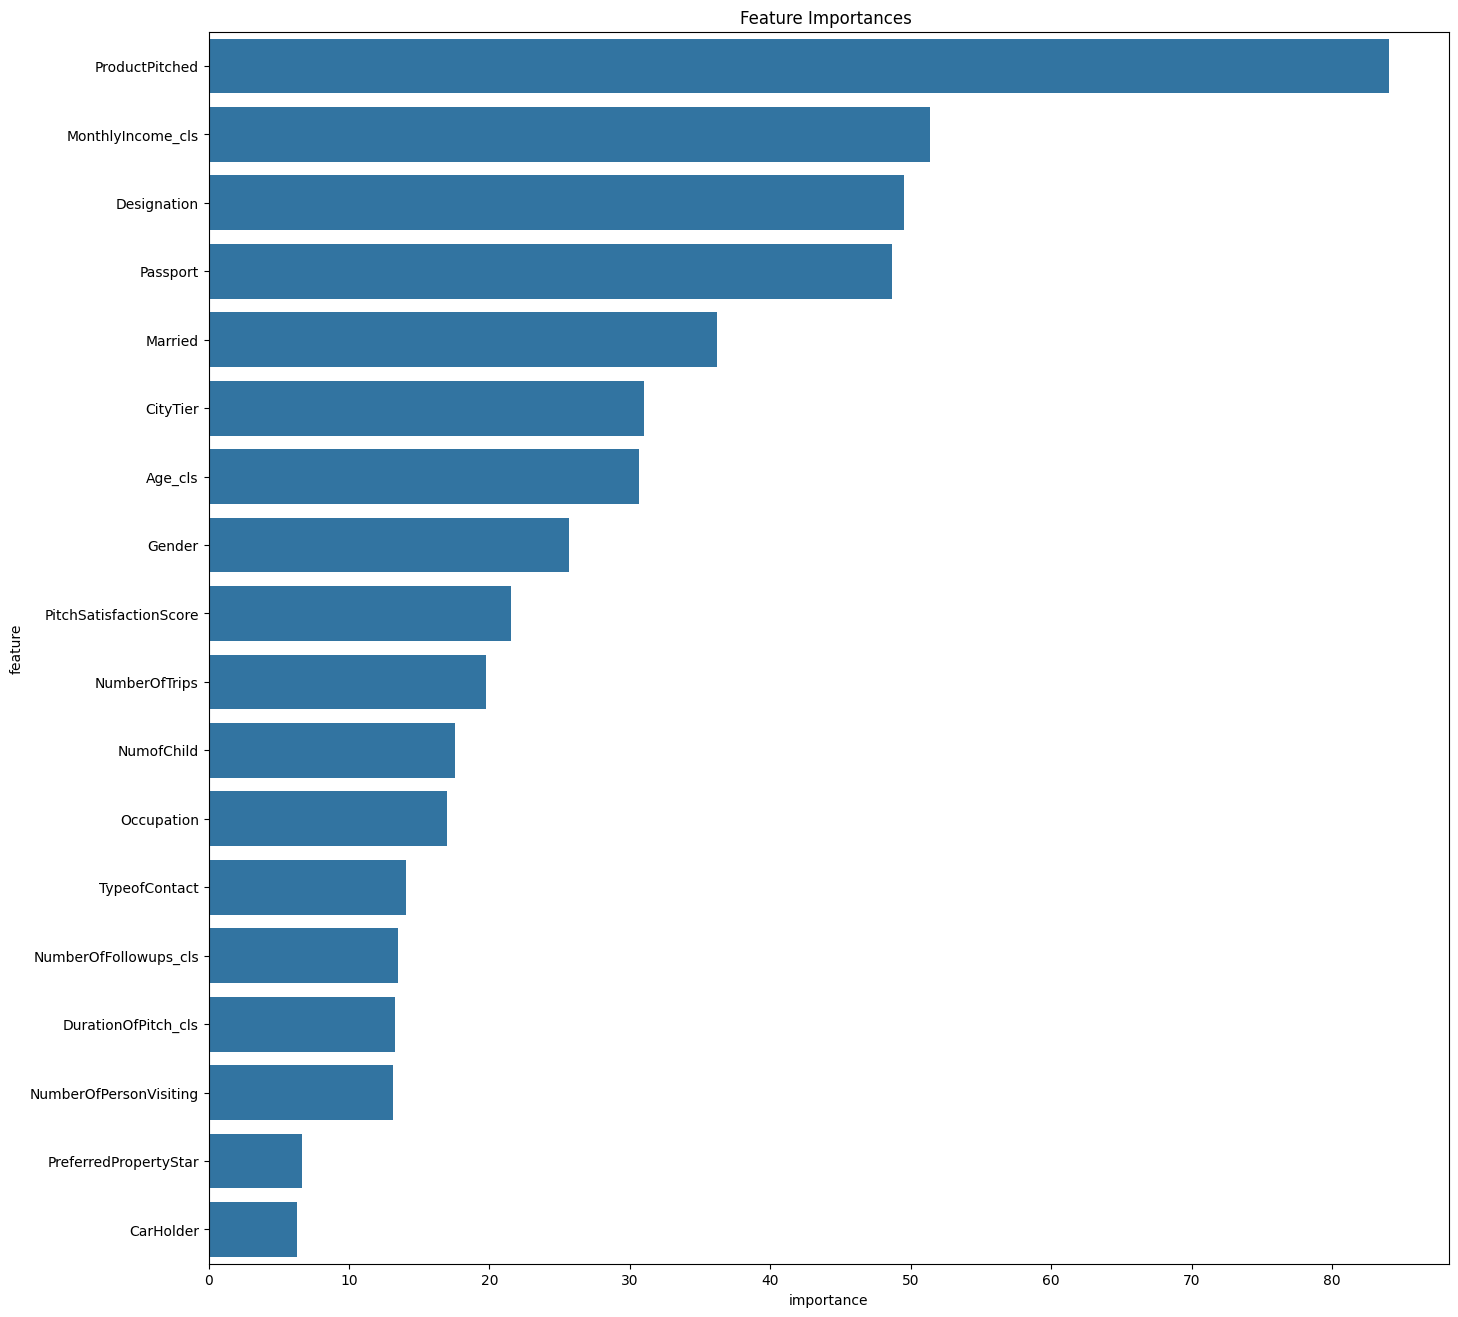

In [233]:
plt.figure(figsize=(16, 16))
sns.barplot(data=o.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances ')

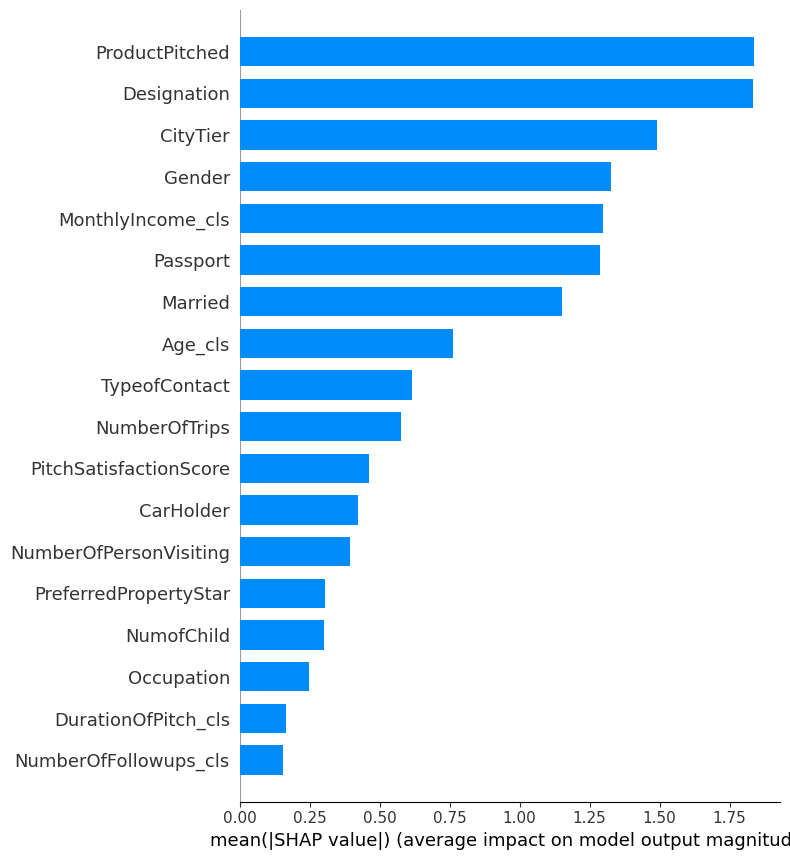

In [234]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(5):
  explainer = shap.TreeExplainer(models[i])
  shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
  shapval = shapval + shap_values

shap.summary_plot(shapval, train.drop("ProdTaken",axis=1),plot_type="bar")